In [1]:
import numpy as np #matrices operations
from torchvision import transforms # Tensor operations to convert images in appropriate form
import matplotlib.pyplot as plt # Plotting tools
import random # Randomizing func
import matplotlib.patches as patches #special tools for drawing bboxes, polygones & other geomety side
from model import * # some for our model
from utils import * # some tools for parcing and drawing for out challenge
from utils_new_ import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn  # ALL OF THIS KNOW
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence # tool for tensor review as a largest sequence

import warnings
warnings.filterwarnings('ignore')

import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as ET
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image

In [2]:
model_detection = torch.load('D:\\For OBject detection\\faster_rcnn_attempt_cars_detection.pt')
model_classify = torch.load('D:\\For OBject detection\\resnet_tuned_adam_tuned_layers.pt')

In [3]:
import glob

In [4]:
image_path_custom = "C:\\Users\\Пользователь\\Desktop\\Python_Development\\German_Cars_classification\\Object_detection\\custom_test\\*.jpg"
image_folder = glob.glob(image_path_custom)
len(image_folder)

10

In [5]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [6]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

In [7]:
img_width = 1024
img_height = 810
annotation_path = "data/annotations.xml"
image_dir = os.path.join("data", "images")
name2idx_cars = {'pad': 0, 'car': 1}
idx2name = {v:k for k, v in name2idx_cars.items()}

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
set_targets = set([0, 1, 2, 3])
names_set = ['audi', 'bmw', 'lamba', 'mercedes']
dict_labels = {}
for i in range(len(set_targets)):
    dict_labels[str(i)] = names_set[i]
dict_labels


{'0': 'audi', '1': 'bmw', '2': 'lamba', '3': 'mercedes'}

In [10]:
def pre_image(image,model):
   img = image
   transform_norm = torchvision.transforms.Compose(
    [
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop(200),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
    [0.0, 0.0, 0.0] , std = [0.9, 0.5, 0.5]
    ),
    torchvision.transforms.RandomHorizontalFlip()
    ]
)
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output = model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      # print(output.data.cpu().numpy()[0])
      # print(index)
      class_name = dict_labels[str(index)]
      return (output.data.numpy()[0][index], class_name)

In [11]:
def crop_preprocess(image):
        image_data_all = []
        images = []
        
        image = Image.open(image)
        image = np.array(image)
        # print(image.shape)
        transform =  transforms.ToTensor()
        img_color = image
        img_color = cv2.resize(img_color, (img_width, img_height))
        
        img_color_tensor = transform(img_color)
        images.append(img_color_tensor)
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        img_res = cv2.resize(img_gray, (img_width, img_height))
        img_res = cv2.GaussianBlur(img_res,(11, 11), 5)
        # diving by 255
        img_res /= 255.0
        transform =  transforms.ToTensor()
        img_tensor = transform(img_res)
        image_data_all.append(img_tensor)
        
        imgs_stacked = torch.stack(images, dim = 0)
        imgs_stacked = imgs_stacked.to(dtype=torch.float32)
        img_data_stacked = torch.stack(image_data_all, dim=0)
        img_data_stacked = img_data_stacked.to(dtype=torch.float32)
        
        with torch.no_grad():
                prediction = model_detection(img_data_stacked.to(device))
        nms_prediction = apply_nms(prediction[0], iou_thresh=0.32)
        # print(nms_prediction)
        bboxes_all = nms_prediction['boxes']
        # class_image_pred = [idx2name[idx.item()] for idx in nms_prediction['labels']]
        return bboxes_all
        
        

In [12]:
def predict_image(image_folder):
    image_data_all = []
    images = []
    for image in image_folder:
        image = Image.open(image)
        image = np.array(image)
        # print(image.shape)
        transform =  transforms.ToTensor()
        img_color = image
        img_color = cv2.resize(img_color, (img_width, img_height))
        
        img_color_tensor = transform(img_color)
        images.append(img_color_tensor)
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        img_res = cv2.resize(img_gray, (img_width, img_height))
        img_res = cv2.GaussianBlur(img_res,(11, 11), 5)
        # diving by 255
        img_res /= 255.0
        transform =  transforms.ToTensor()
        img_tensor = transform(img_res)
        image_data_all.append(img_tensor)
    imgs_stacked = torch.stack(images, dim = 0)
    imgs_stacked = imgs_stacked.to(dtype=torch.float32)
    img_data_stacked = torch.stack(image_data_all, dim=0)
    img_data_stacked = img_data_stacked.to(dtype=torch.float32)

    # return img_data_stacked
    nrows, ncols = (len(image_folder), 1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(50, 50))
    with torch.no_grad():
        prediction = model_detection(img_data_stacked.to(device))
    # print(prediction)
    for i in range(len(image_folder)):
        # print(img_data_stacked[i].size())
        nms_prediction = apply_nms(prediction[i], iou_thresh=0.32)
        # print(nms_prediction)
        bboxes_all = nms_prediction['boxes']
        class_image_pred = [idx2name[idx.item()] for idx in nms_prediction['labels']]
        # img_data_stacked = img_data_stacked.to(dtype=torch.float32)
    # nrows, ncols = (1, len(image_folder))
    # fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

        my_bboxes = crop_preprocess(image_folder[i])
        bboxes = my_bboxes.numpy()
        bboxes = bboxes.astype('int')
        idx = 0
        for box in bboxes:
    
            image = Image.open(image_folder[i])
    
            image_numpy = np.array(image)
            img_color = image_numpy
            img_color = cv2.resize(img_color, (img_width, img_height))
    
            image = Image.fromarray(img_color)
            box = tuple(box)
            image = image.crop(box) 
    
            predict_brand = pre_image(model = model_classify, image=image)
            # print(predict_brand)
            
            if predict_brand[0] >= 3.0:
                class_image_pred[idx] = predict_brand[1]
            idx+=1
        
        fig, axes = display_img(imgs_stacked, fig, axes)
        fig, _ = display_bbox(bboxes_all, fig, axes[i], classes=class_image_pred)
    

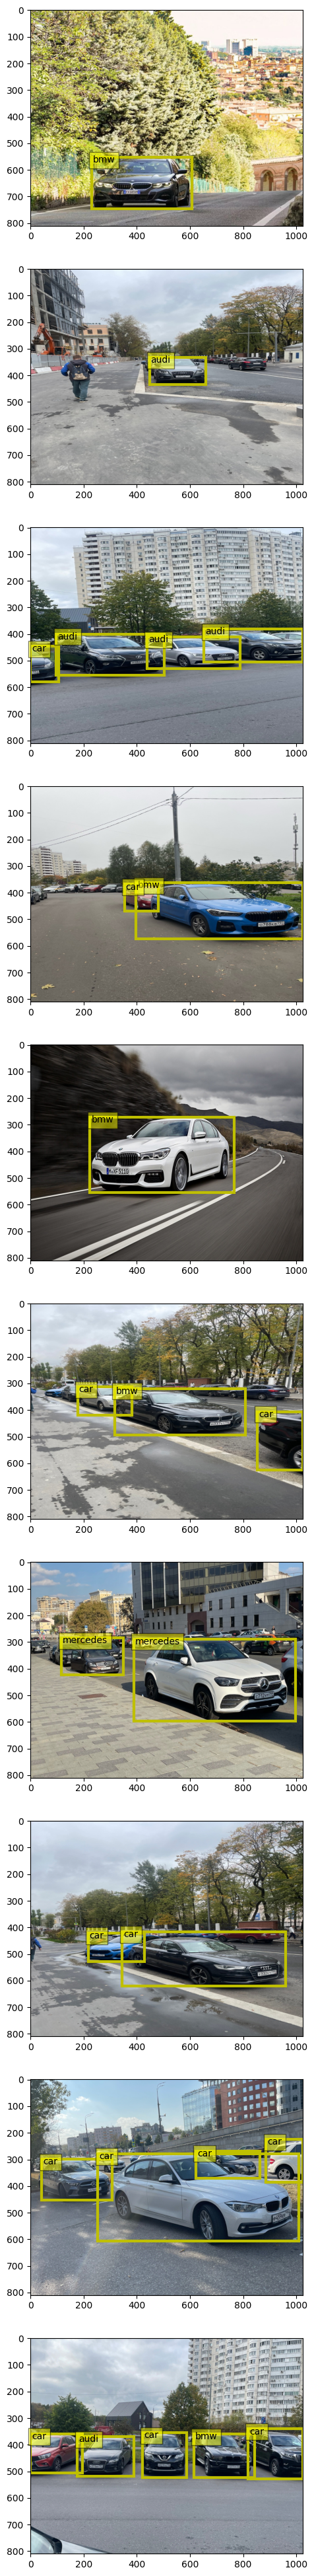

In [13]:
predict_image(image_folder)

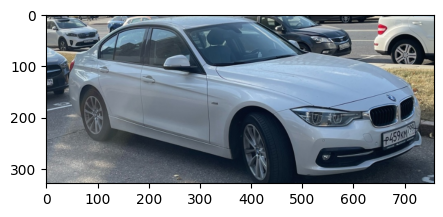

(5.048338, 'bmw')


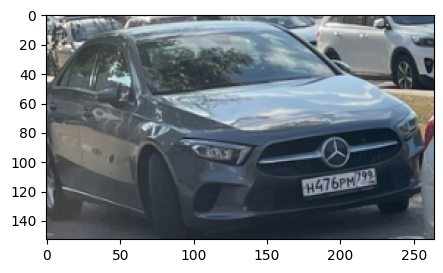

(2.985339, 'mercedes')


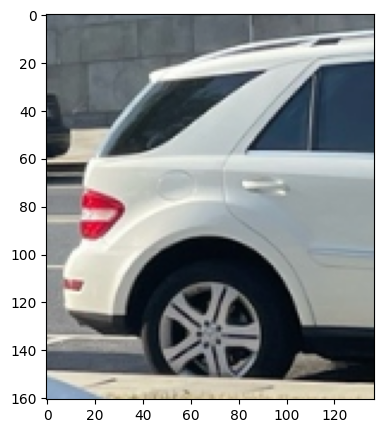

(0.49278307, 'mercedes')


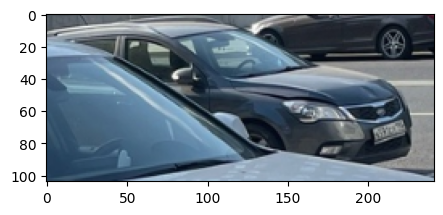

(1.6626529, 'mercedes')


In [73]:
bboxes_1 = crop_preprocess(image_folder[0])
bboxes_1 = bboxes_1.numpy()
bboxes_1 = bboxes_1.astype('int')
for box in bboxes_1:
    
    image = Image.open(image_folder[0])
    
    image_numpy = np.array(image)
    img_color = image_numpy
    img_color = cv2.resize(img_color, (img_width, img_height))
    
    image = Image.fromarray(img_color)
    box = tuple(box)
    image = image.crop(box) 
    
    predict_brand = pre_image(model = model_classify, image=image)
    
    figure = plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()
    print(predict_brand)